In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.collections import LineCollection

data = pd.read_csv('cleaned_data.csv')

/tmp/ipykernel_46678/742889855.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('cleaned_data.csv')


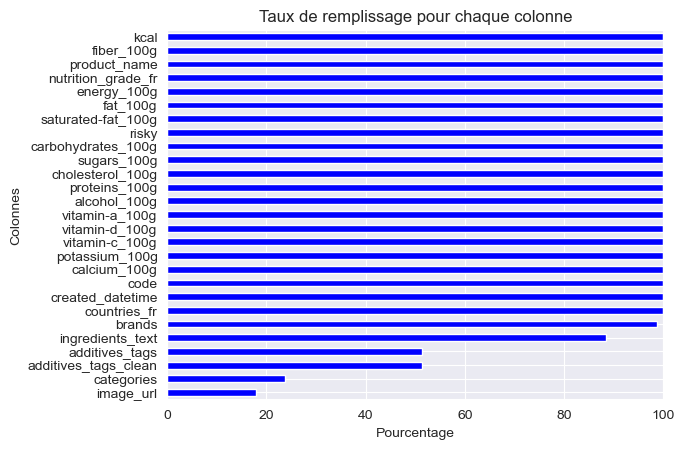

In [161]:
#taux de remplissage des variables
missing_values = 100*(data.notnull().mean())
missing_values = missing_values.sort_values(ascending=True)
missing_values.plot(kind='barh',title='Taux de remplissage pour chaque colonne', color='blue', xlim=[0,100])
plt.xlabel('Pourcentage')
plt.ylabel('Colonnes')
plt.show()

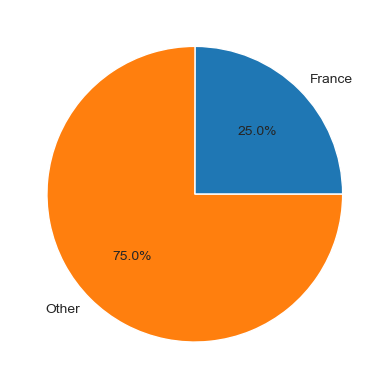

In [162]:
#répartition produits français
france_data = data[data['countries_fr'].str.contains('France', na=False)]
other_data = data[~data['countries_fr'].str.contains('France', na=False)]
france_percentage = len(france_data) / len(data) * 100
other_percentage = len(other_data) / len(data) * 100
plt.pie([france_percentage, other_percentage], labels=['France', 'Other'], autopct='%1.1f%%')
plt.show()

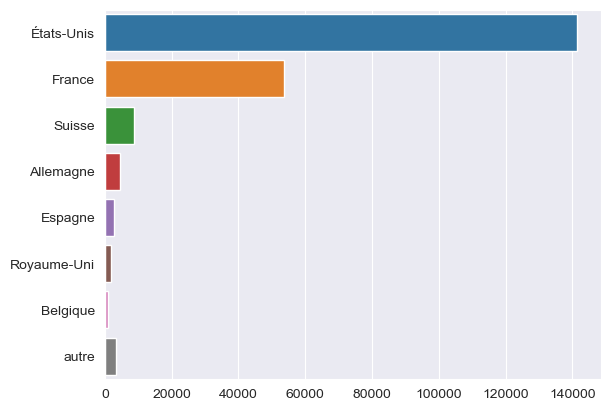

In [163]:
#répartition des produits par pays
pays = [
    "Afrique du Sud","Albanie","Algérie","Allemagne","Andorre","Angola","Arabie saoudite","Argentine","Arménie","Australie","Autriche","Azerbaïdjan",
    "Bahreïn","Bangladesh","Belgique","Belize","Bénin","Bhoutan","Biélorussie","Bolivie","Bosnie-Herzégovine","Botswana","Brésil","Brunei","Bulgarie","Burkina Faso","Burundi",
    "Cambodge","Cameroun","Canada","Cap-Vert","Chili","Chine","Chypre","Colombie","Comores","Congo","Corée du Nord","Corée du Sud","Costa Rica","Côte d'Ivoire","Croatie","Cuba",
    "Danemark","Djibouti","Dominique",
    "Égypte","Émirats arabes unis","Équateur","Érythrée","Espagne","Estonie","États-Unis","Éthiopie",
    "Fidji","Finlande","France",
    "Gabon","Gambie","Géorgie","Ghana","Grèce","Grenade","Guatemala","Guinée","Guinée-Bissau","Guinée équatoriale","Guyana",
    "Haïti","Honduras","Hong Kong","Hongrie",
    "Îles Marshall","Inde","Indonésie","Irak","Iran","Irlande","Islande","Israël","Italie",
    "Jamaïque","Japon","Jordanie",
    "Kazakhstan","Kenya","Kirghizistan","Kiribati","Koweït",
    "Laos","Lesotho","Lettonie","Liban","Liberia","Libye","Liechten","Liban","Lituanie","Luxembourg",
    "Malaisie","Malawi", "Mali", "Malte", "Maroc", "Maurice", "Mauritanie", "Mexique", "Moldavie", "Monaco","Mongolie", "Monténégro",
    "Nigeria", "Norvège", "Nouvelle-Calédonie", "Nouvelle-Zélande",
    "Oman",
    "Pays-Bas", "Pérou", "Philippines", "Pologne", "Portugal",
    "Qatar",
    "Roumanie", "Royaume-Uni", "République centrafricaine", "République dominicaine", "République tchèque",
    "Salvador", "Serbie", "Singapour", "Slovaquie", "Slovénie", "Suède",    "Suisse",
    "Taiwan", "Tanzanie", "Thaïlande", "Togo", "Tunisie", "Turquie",
    "Ukraine",
    "Venezuela", "Viêt Nam",
    "Yémen",
    "Zambie", "Zimbabwe"
]

data['countries_split'] = data['countries_fr'].str.split(',')
countries_series = data['countries_split'].explode().value_counts()
filtered_series = countries_series[countries_series.index.isin(pays)]

seuil = 1000
pays = filtered_series.loc[filtered_series >= seuil]
autre = pd.Series([filtered_series.loc[filtered_series < seuil].sum()], index=['autre'])
reordered_series =  pd.concat([pays, autre])

sns.barplot(x=reordered_series.values, y=reordered_series.index)
plt.show()

Le nombre de lignes data avant action est 214371


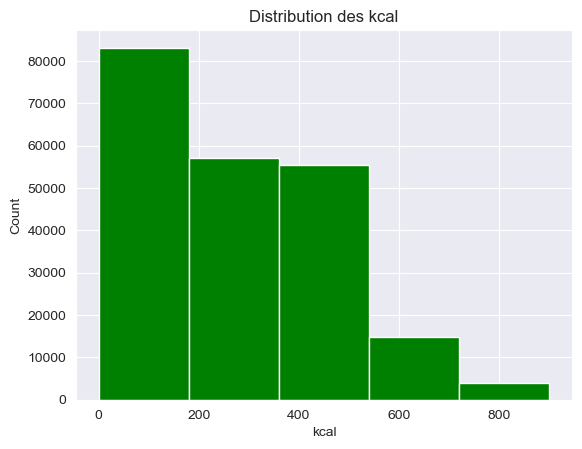

In [164]:
data_before_action = data.shape[0]
print(f'Le nombre de lignes data avant action est {data_before_action}')

# (Distribution du nombre de produits par tranche d'énergie)
bins = 5

# # Plot the histogram
data['kcal'].hist(bins=bins, rwidth=1, color='g')

# # Add axis labels and plot title
plt.xlabel("kcal")
plt.ylabel("Count")
plt.title("Distribution des kcal")
plt.show()

Médiane des calories 267.66
Mode des calories 0    400.0
Name: kcal, dtype: float64
Moyenne des calories 273.1895502098959
Variance 37260.76733263409
Ecart type 193.03093313727635


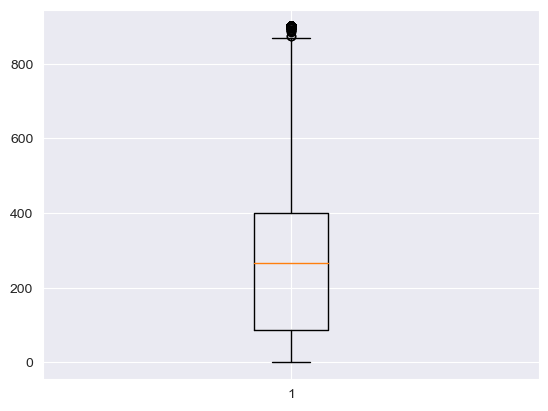

In [165]:
# Créer un diagramme en boîte à moustache pour les calories
plt.boxplot(data["kcal"])
print(f'Médiane des calories {data["kcal"].median()}')
print(f'Mode des calories {data["kcal"].mode()}')
print(f'Moyenne des calories {data["kcal"].mean()}')
print(f'Variance {data["kcal"].var(ddof=0)}')
print(f'Ecart type {data["kcal"].std()}')

# on constate que la médiane est proche de la moyenne ce qui témoigne d'une répartition assez équilibrée, et les outliers ne perturbent pas la moyenne

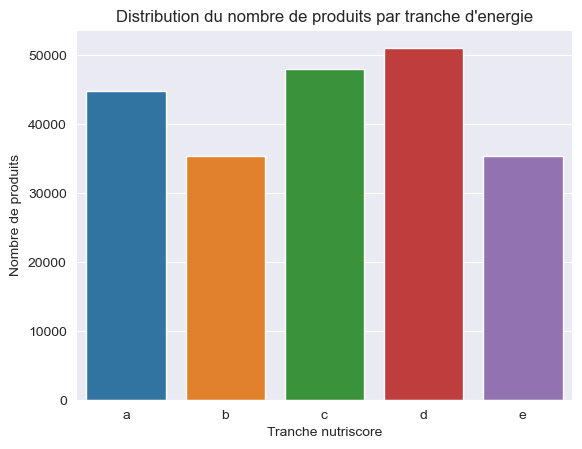

d    51033
c    47976
a    44744
b    35341
e    35277
Name: nutrition_grade_fr, dtype: int64
Mode nutri 0    d
Name: nutrition_grade_fr, dtype: object


In [166]:
order = ['a','b','c','d','e']
sns.countplot(x='nutrition_grade_fr', data=data, order=order)

# Set the plot's title and axis labels
plt.title("Distribution du nombre de produits par tranche d'energie")
plt.xlabel("Tranche nutriscore")
plt.ylabel("Nombre de produits")
# Display the plot
plt.show()
# Print the counts of each value
print(data['nutrition_grade_fr'].value_counts())
print(f'Mode nutri {data["nutrition_grade_fr"].mode()}')

# l'imputation par le calcul du nutriscore joue en faveur de la note A, mais il faut garder en tête que les valeurs manquantes
# à 35% pour les sucres et les graisses saturées peuvent expliquer cela

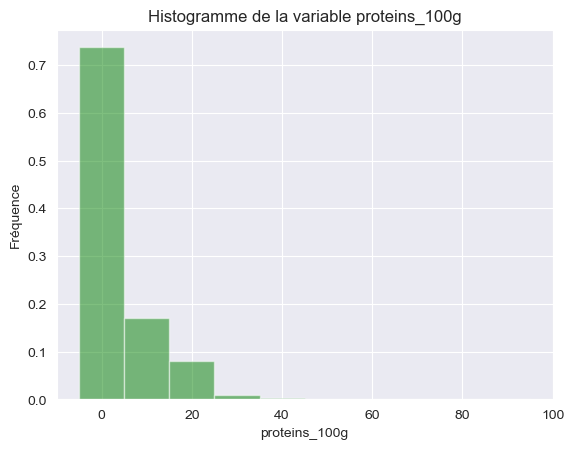

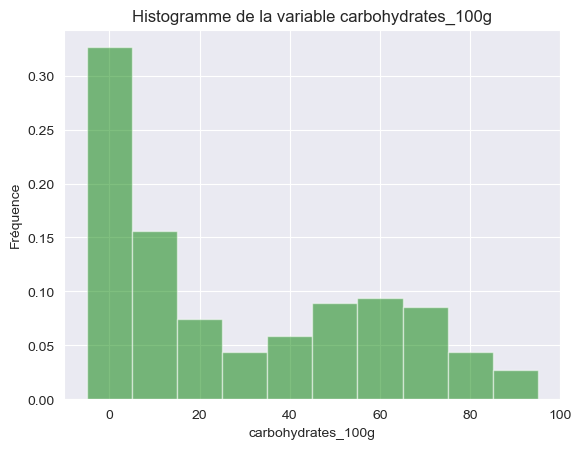

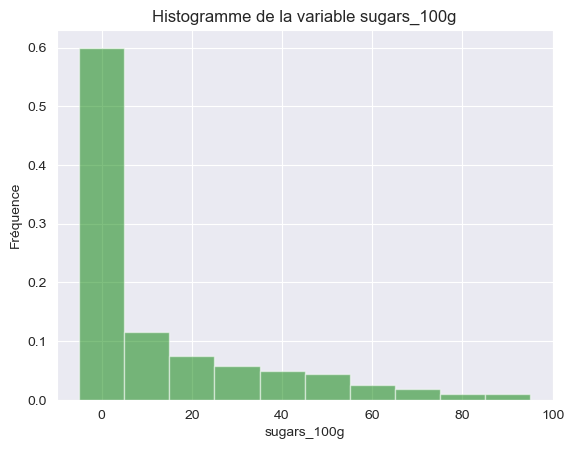

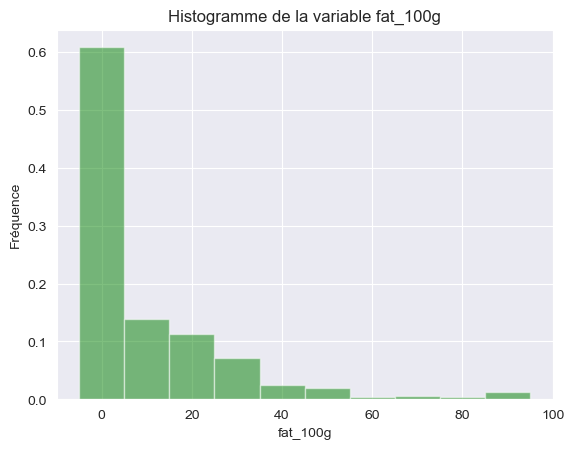

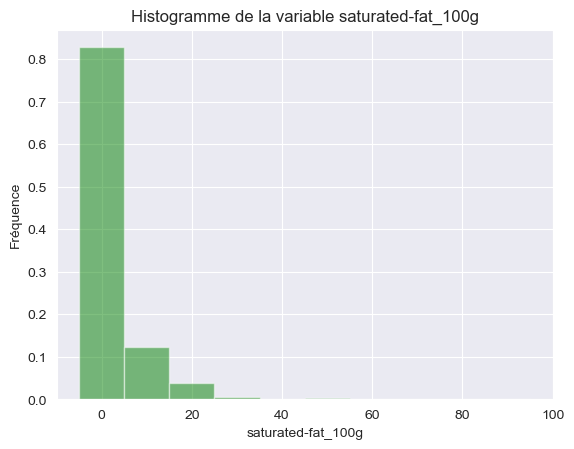

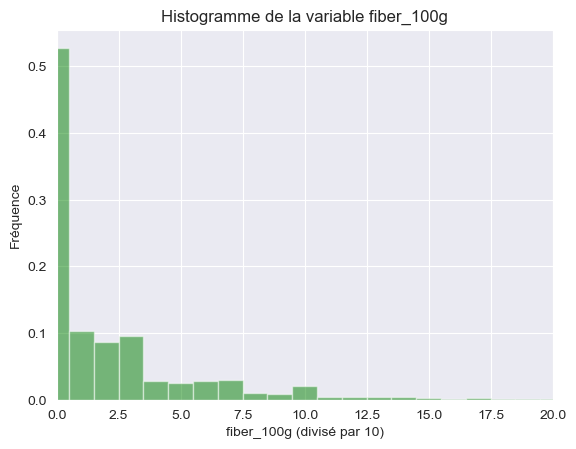

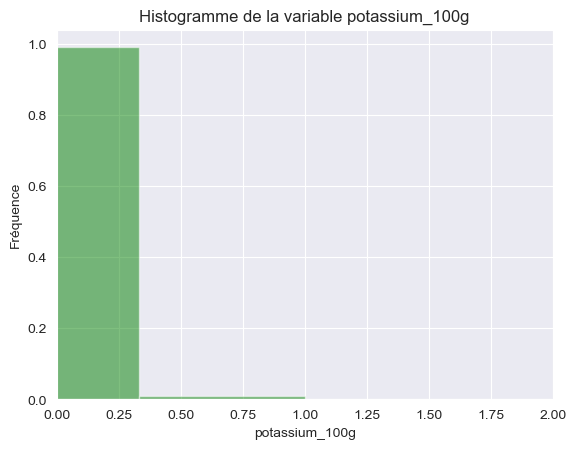

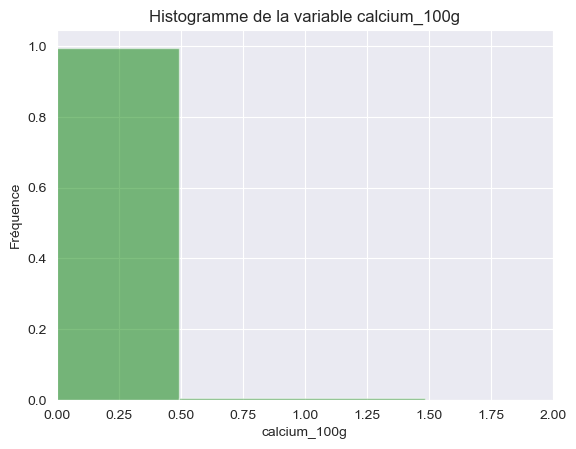

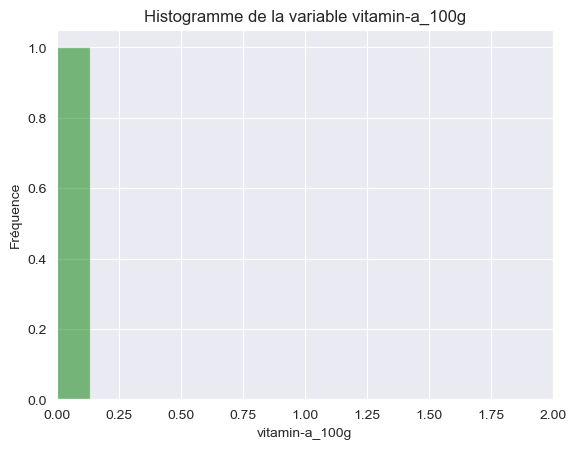

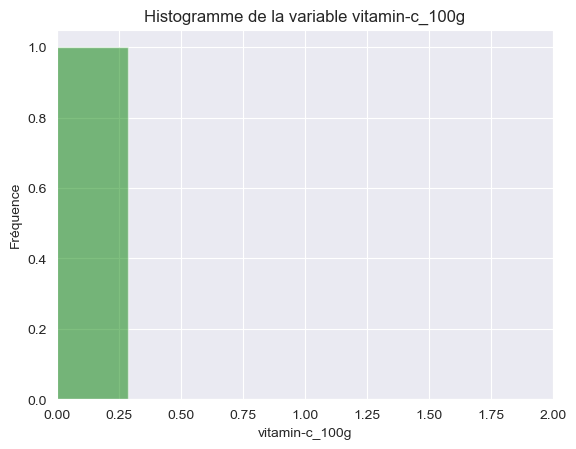

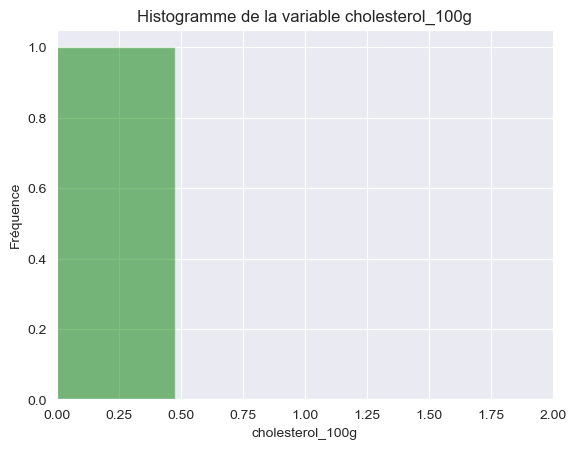

In [167]:
# Création des tranches pour l'histogramme
#Liste de variables quantitatives
quant_vars = ['proteins_100g', 'carbohydrates_100g', 'sugars_100g','fat_100g', 'saturated-fat_100g']

# Boucle à travers les variables quantitatives
for var in quant_vars:
    # Calcule les effectifs, les fréquences, les fréquences cumulées
    counts, bin_edges = np.histogram(data[var], bins = 10, density = False)
    freqs = counts / len(data[var])
    cdf = np.cumsum(freqs)

    # Tracer l'histogramme
    plt.bar(bin_edges[:-1], freqs, width = bin_edges[1] - bin_edges[0], color = 'g', alpha = 0.5)
    plt.xlabel(var)
    plt.ylabel("Fréquence")
    plt.title("Histogramme de la variable "+ var)
    plt.show()

quant_vars = ['fiber_100g']
for var in quant_vars:
    # Calcule les effectifs, les fréquences, les fréquences cumulées
    counts, bin_edges = np.histogram(data[var], bins = 100, density = False)
    freqs = counts / len(data[var])
    cdf = np.cumsum(freqs)

    # Tracer l'histogramme
    plt.bar(bin_edges[:-1], freqs, width = bin_edges[1] - bin_edges[0], color = 'g', alpha = 0.5)
    plt.xlabel(var + ' (divisé par 10)')
    plt.ylabel("Fréquence")
    plt.title("Histogramme de la variable "+ var)
    plt.xlim(0, 20)
    plt.show()

quant_vars = ['potassium_100g','calcium_100g','vitamin-a_100g','vitamin-c_100g','cholesterol_100g']
for var in quant_vars:
    # Calcule les effectifs, les fréquences, les fréquences cumulées
    counts, bin_edges = np.histogram(data[var], bins = 100, density = False)
    freqs = counts / len(data[var])
    cdf = np.cumsum(freqs)

    # Tracer l'histogramme
    plt.bar(bin_edges[:-1], freqs, width = bin_edges[1] - bin_edges[0], color = 'g', alpha = 0.5)
    plt.xlabel(var)
    plt.ylabel("Fréquence")
    plt.title("Histogramme de la variable "+ var)
    plt.xlim(0, 2)
    plt.show()

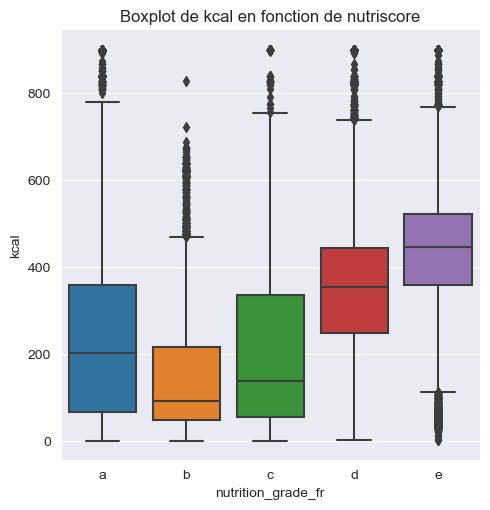

In [168]:
#  une hypothèse pourrait être que plus les calories d'un produit alimentaire sont élevées, plus il y a de chances que son nutriscore soit faible. Cela s'appuie sur l'idée que les produits alimentaires riches en calories ont tendance à être plus riches en matières grasses, sucres etc  ..
# Utiliser la fonction boxplot de seaborn pour créer un boxplot pour chaque niveau de nutriscore
sns.catplot(x="nutrition_grade_fr", y="kcal", data=data, kind="box", order=["a", "b", "c", "d", "e"])

plt.title("Boxplot de kcal en fonction de nutriscore")
plt.show()

#on rappelle que les meilleures notes sont probablement tirées vers le haut dû au valeurs manquantes à 35% des sucres et 35% des graisses saturées.
# partant de là, on peut observer une relation assez linéaire qui pourrait appuyer l'hypothèse. Des tests statistiques doivent être faits.
#on note aussi une plus forte dispersion autour de la médiane pour les notes A et C comparées aux autres

In [169]:
X = "nutrition_grade_fr" # qualitative
Y = "kcal" # quantitative


def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT


# Mapping des valeurs qualitatives ordinales
map_dict = {'a':1, 'b':2, 'c':3, 'd':4, 'e':5}
data['nutrition_grade_fr'] = data['nutrition_grade_fr'].replace({'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5})

# covar(x,y) = 1/n * Σ((x_i - x̄) * (y_i - ȳ))
covar_x_y = data['kcal'].cov(data['nutrition_grade_fr'])
sx = data['kcal'].std()
sy = data['nutrition_grade_fr'].std()
ro_x_y = covar_x_y / sx * sy

print(f'Rapport de corrélation eta carré: {eta_squared(data[X], data[Y])}')
print(f'Coefficient de corrélation covar(x,y)/sx*sy: {ro_x_y}')

print('Le rapport indique que 26% des variations de kcal peuvent être expliquées par le nutriscore et qu\'il y a une corrélation linéaire')



Rapport de corrélation eta carré: 0.26341635456723367
Coefficient de corrélation covar(x,y)/sx*sy: 0.7650022502417806
Le rapport indique que 26% des variations de kcal peuvent être expliquées par le nutriscore et qu'il y a une corrélation linéaire


<AxesSubplot:>

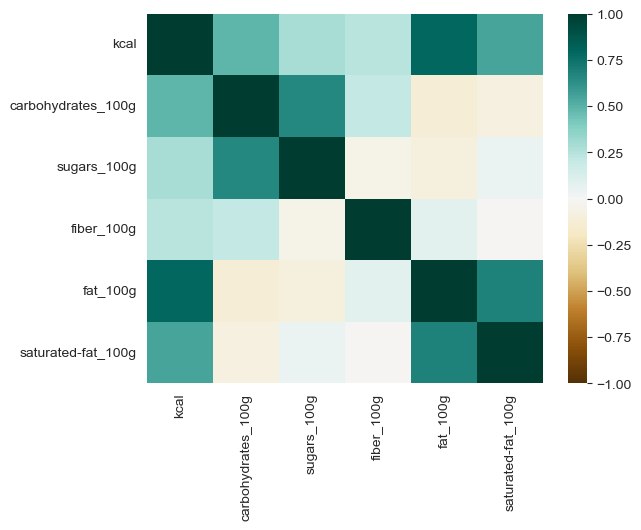

In [170]:
variables_quant = ['kcal','carbohydrates_100g', 'sugars_100g','fiber_100g','fat_100g', 'saturated-fat_100g']
sns.heatmap(data[variables_quant].corr(), vmin=-1, vmax=1, cmap="BrBG")

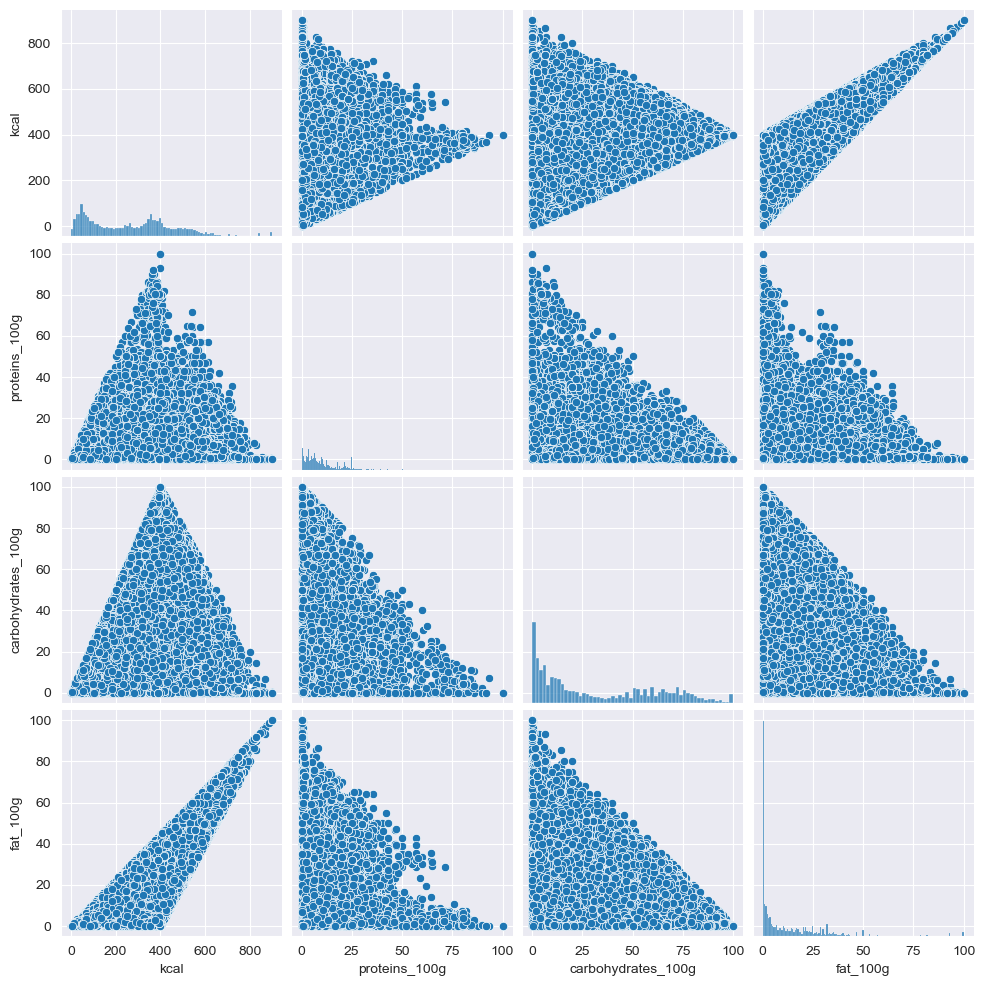

In [171]:
sns.pairplot(data[["kcal","proteins_100g","carbohydrates_100g","fat_100g"]])


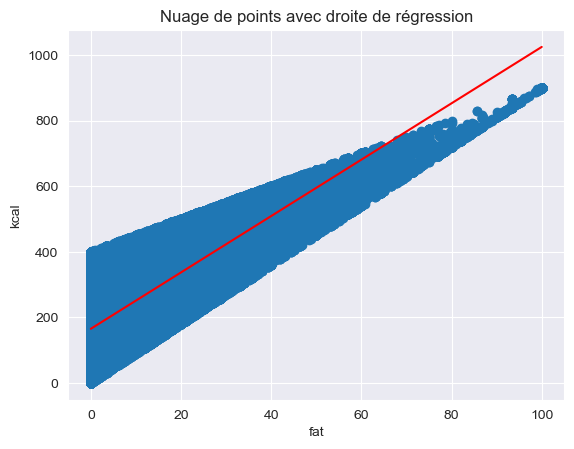

Le coefficient de détermination R2: 0.6284403295007823 est une bonne performance pour une régression linéaire


In [172]:
dataf = {'x': data['fat_100g'], 'y': data['kcal']}
df = pd.DataFrame(dataf)

# Régression linéaire
model = smf.ols(formula='y ~ x', data=df)
results = model.fit()

# Coefficients de la droite de régression
a = results.params['x']
b = results.params['Intercept']

# Calcul des valeurs de la droite de régression pour x
x_range = range(int(min(df['x'])), int(max(df['x']))+1)
y_reg = [a*i + b for i in x_range]

# Création du graphique
plt.scatter(df['x'], df['y'])
plt.plot(x_range, y_reg, color='red')

# Ajout d'un titre et d'étiquettes d'axes
plt.title("Nuage de points avec droite de régression")
plt.xlabel("fat")
plt.ylabel("kcal")

# Affichage du graphique
plt.show()

#est-ce que le modèle de régression linéaire est cohérent?
R2 = results.rsquared
print(f'Le coefficient de détermination R2: {R2} est une bonne performance pour une régression linéaire')


In [173]:
cols = ['energy_100g','fat_100g','saturated-fat_100g','cholesterol_100g','carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g','alcohol_100g','vitamin-a_100g','vitamin-d_100g','potassium_100g','calcium_100g','kcal']
data_acp = data[cols].copy()
data_acp.head()

energy_100g  fat_100g  saturated-fat_100g  cholesterol_100g  \
0       2243.0     28.57               28.57             0.018   
1       1941.0     17.86                0.00             0.000   
2       2540.0     57.14                5.36             0.000   
3       1552.0      1.43                0.00             0.000   
4       1933.0     18.27                1.92             0.000   

   carbohydrates_100g  sugars_100g  fiber_100g  proteins_100g  alcohol_100g  \
0               64.29        14.29         3.6           3.57           0.0   
1               60.71        17.86         7.1          17.86           0.0   
2               17.86         3.57         7.1          17.86           0.0   
3               77.14         0.00         5.7           8.57           0.0   
4               63.46        11.54         7.7          13.46           0.0   

   vitamin-a_100g  vitamin-d_100g  potassium_100g  calcium_100g    kcal  
0             0.0             0.0             0.0         0.000  528.57  
1             0.0             0.0             0.0         0.071  475.02  
2             0.0             0.0             0.0         0.143  657.14  
3             0.0             0.0             0.0         0.000  355.71  
4             0.0             0.0             0.0         0.038  472.11

In [174]:
data_acp.shape

(214371, 14)

In [175]:
X = data_acp.values
X[:5]

array([[2.2430e+03, 2.8570e+01, 2.8570e+01, 1.8000e-02, 6.4290e+01,
        1.4290e+01, 3.6000e+00, 3.5700e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 5.2857e+02],
       [1.9410e+03, 1.7860e+01, 0.0000e+00, 0.0000e+00, 6.0710e+01,
        1.7860e+01, 7.1000e+00, 1.7860e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 7.1000e-02, 4.7502e+02],
       [2.5400e+03, 5.7140e+01, 5.3600e+00, 0.0000e+00, 1.7860e+01,
        3.5700e+00, 7.1000e+00, 1.7860e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.4300e-01, 6.5714e+02],
       [1.5520e+03, 1.4300e+00, 0.0000e+00, 0.0000e+00, 7.7140e+01,
        0.0000e+00, 5.7000e+00, 8.5700e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.5571e+02],
       [1.9330e+03, 1.8270e+01, 1.9200e+00, 0.0000e+00, 6.3460e+01,
        1.1540e+01, 7.7000e+00, 1.3460e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 3.8000e-02, 4.7211e+02]])

In [176]:
names = data_acp.index
names

RangeIndex(start=0, stop=214371, step=1)

In [177]:
features = data_acp.columns
features

Index(['energy_100g', 'fat_100g', 'saturated-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'alcohol_100g', 'vitamin-a_100g', 'vitamin-d_100g', 'potassium_100g',
       'calcium_100g', 'kcal'],
      dtype='object')

In [178]:
scaler = StandardScaler()

In [179]:
scaler.fit(X)

StandardScaler()

In [180]:
X_scaled = scaler.transform(X)
X_scaled[:5]

array([[ 0.1487499 ,  0.89803571,  3.03893507,  0.0239881 ,  1.07038539,
        -0.07820367,  0.27146319, -0.44084467,  0.        , -0.00398836,
        -0.03359402, -0.12733529, -0.12643538,  1.32300581],
       [ 0.10609558,  0.29653069, -0.58633045, -0.03735238,  0.94843538,
         0.08694361,  1.07025902,  1.33143907,  0.        , -0.00398836,
        -0.03359402, -0.12733529,  0.02580156,  1.04558848],
       [ 0.19069803,  2.50261071,  0.09380337, -0.03735238, -0.51121762,
        -0.57410811,  1.07025902,  1.33143907,  0.        , -0.00398836,
        -0.03359402, -0.12733529,  0.18018269,  1.98906641],
       [ 0.05115342, -0.6262263 , -0.58633045, -0.03735238,  1.50811097,
        -0.73925539,  0.75074069,  0.17926861,  0.        , -0.00398836,
        -0.03359402, -0.12733529, -0.12643538,  0.42749958],
       [ 0.10496567,  0.3195575 , -0.34270043, -0.03735238,  1.04211206,
        -0.20541797,  1.20719545,  0.78573939,  0.        , -0.00398836,
        -0.03359402, -0.12

In [181]:
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

0    1    2    3    4    5    6    7    8    9    10   11   12   13
mean -0.0 -0.0  0.0 -0.0  0.0  0.0  0.0 -0.0  0.0  0.0 -0.0  0.0  0.0  0.0
std   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

In [182]:
n_components = 6

In [183]:
pca = PCA(n_components=n_components)

In [184]:
pca.fit(X_scaled)

PCA(n_components=6)

In [185]:
pca.explained_variance_ratio_

array([0.19673941, 0.14674879, 0.10135862, 0.09573279, 0.0772406 ,
       0.07685444])

In [186]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([19.67, 14.67, 10.14,  9.57,  7.72,  7.69])

In [187]:
scree_cum = scree.cumsum().round()
scree_cum

array([20., 34., 44., 54., 62., 69.])

In [188]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6]

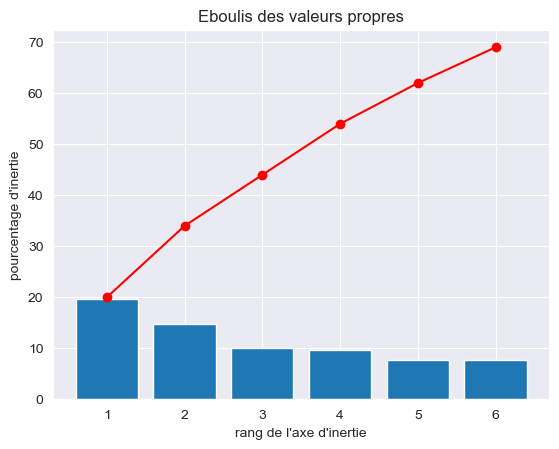

In [189]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [190]:
pcs = pca.components_
pcs

array([[ 1.04494704e-01,  5.31539285e-01,  4.66715420e-01,
         2.05769862e-02,  1.85310193e-01,  1.28195630e-01,
         1.75900974e-01,  2.24283191e-01,  4.23516474e-22,
         1.42678932e-02,  4.14987005e-03,  3.39484039e-02,
         7.12141757e-02,  5.91470467e-01],
       [-2.70669890e-02,  2.28756319e-01,  1.86328964e-01,
         5.05328337e-02, -6.29398705e-01, -6.12210228e-01,
        -4.58648396e-02,  3.16809598e-01,  5.42101086e-20,
         4.43040884e-02, -8.66566501e-03, -2.44997766e-02,
         1.18325434e-01, -1.40038503e-01],
       [ 7.04262371e-04, -1.75360307e-01, -2.03861921e-01,
         2.59122964e-03,  1.43075420e-01, -1.72590460e-02,
         3.34063107e-01,  2.53284379e-01,  1.66533454e-16,
         5.72075872e-01,  7.06917850e-02,  2.06370611e-01,
         5.96692667e-01, -1.62229233e-02],
       [-3.31533244e-02,  1.17254700e-01,  2.39821363e-01,
         4.38826791e-02, -9.31228368e-02,  1.87649128e-01,
        -5.90228063e-01, -3.65378691e-01, -1.

In [191]:
pcs = pd.DataFrame(pcs)
pcs

0         1         2         3         4         5         6   \
0  0.104495  0.531539  0.466715  0.020577  0.185310  0.128196  0.175901   
1 -0.027067  0.228756  0.186329  0.050533 -0.629399 -0.612210 -0.045865   
2  0.000704 -0.175360 -0.203862  0.002591  0.143075 -0.017259  0.334063   
3 -0.033153  0.117255  0.239821  0.043883 -0.093123  0.187649 -0.590228   
4 -0.123238  0.047164  0.056011  0.073532 -0.039271  0.018556 -0.141224   
5 -0.047973 -0.054732 -0.022321  0.988711  0.046252  0.043340  0.001367   

         7             8         9         10        11        12        13  
0  0.224283  4.235165e-22  0.014268  0.004150  0.033948  0.071214  0.591470  
1  0.316810  5.421011e-20  0.044304 -0.008666 -0.024500  0.118325 -0.140039  
2  0.253284  1.665335e-16  0.572076  0.070692  0.206371  0.596693 -0.016223  
3 -0.365379 -1.734723e-18  0.420022 -0.047545 -0.321240  0.343030 -0.020356  
4 -0.097134  1.110223e-16 -0.037388  0.929140  0.279317 -0.007789 -0.000965  
5  0.067610  2.498002e-16 -0.054322 -0.067122 -0.023896  0.000885 -0.006004

In [192]:
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

energy_100g  fat_100g  saturated-fat_100g  cholesterol_100g  \
F1         0.10      0.53                0.47              0.02   
F2        -0.03      0.23                0.19              0.05   
F3         0.00     -0.18               -0.20              0.00   
F4        -0.03      0.12                0.24              0.04   
F5        -0.12      0.05                0.06              0.07   
F6        -0.05     -0.05               -0.02              0.99   

    carbohydrates_100g  sugars_100g  fiber_100g  proteins_100g  alcohol_100g  \
F1                0.19         0.13        0.18           0.22           0.0   
F2               -0.63        -0.61       -0.05           0.32           0.0   
F3                0.14        -0.02        0.33           0.25           0.0   
F4               -0.09         0.19       -0.59          -0.37          -0.0   
F5               -0.04         0.02       -0.14          -0.10           0.0   
F6                0.05         0.04        0.00           0.07           0.0   

    vitamin-a_100g  vitamin-d_100g  potassium_100g  calcium_100g  kcal  
F1            0.01            0.00            0.03          0.07  0.59  
F2            0.04           -0.01           -0.02          0.12 -0.14  
F3            0.57            0.07            0.21          0.60 -0.02  
F4            0.42           -0.05           -0.32          0.34 -0.02  
F5           -0.04            0.93            0.28         -0.01 -0.00  
F6           -0.05           -0.07           -0.02          0.00 -0.01

In [193]:
pcs.T

F1            F2            F3            F4  \
energy_100g         1.044947e-01 -2.706699e-02  7.042624e-04 -3.315332e-02   
fat_100g            5.315393e-01  2.287563e-01 -1.753603e-01  1.172547e-01   
saturated-fat_100g  4.667154e-01  1.863290e-01 -2.038619e-01  2.398214e-01   
cholesterol_100g    2.057699e-02  5.053283e-02  2.591230e-03  4.388268e-02   
carbohydrates_100g  1.853102e-01 -6.293987e-01  1.430754e-01 -9.312284e-02   
sugars_100g         1.281956e-01 -6.122102e-01 -1.725905e-02  1.876491e-01   
fiber_100g          1.759010e-01 -4.586484e-02  3.340631e-01 -5.902281e-01   
proteins_100g       2.242832e-01  3.168096e-01  2.532844e-01 -3.653787e-01   
alcohol_100g        4.235165e-22  5.421011e-20  1.665335e-16 -1.734723e-18   
vitamin-a_100g      1.426789e-02  4.430409e-02  5.720759e-01  4.200216e-01   
vitamin-d_100g      4.149870e-03 -8.665665e-03  7.069178e-02 -4.754468e-02   
potassium_100g      3.394840e-02 -2.449978e-02  2.063706e-01 -3.212398e-01   
calcium_100g        7.121418e-02  1.183254e-01  5.966927e-01  3.430297e-01   
kcal                5.914705e-01 -1.400385e-01 -1.622292e-02 -2.035630e-02   

                              F5            F6  
energy_100g        -1.232377e-01 -4.797264e-02  
fat_100g            4.716381e-02 -5.473207e-02  
saturated-fat_100g  5.601071e-02 -2.232120e-02  
cholesterol_100g    7.353197e-02  9.887114e-01  
carbohydrates_100g -3.927054e-02  4.625184e-02  
sugars_100g         1.855622e-02  4.334046e-02  
fiber_100g         -1.412244e-01  1.366668e-03  
proteins_100g      -9.713356e-02  6.761021e-02  
alcohol_100g        1.110223e-16  2.498002e-16  
vitamin-a_100g     -3.738827e-02 -5.432177e-02  
vitamin-d_100g      9.291398e-01 -6.712150e-02  
potassium_100g      2.793170e-01 -2.389631e-02  
calcium_100g       -7.788828e-03  8.850181e-04  
kcal               -9.646666e-04 -6.004238e-03

<AxesSubplot:>

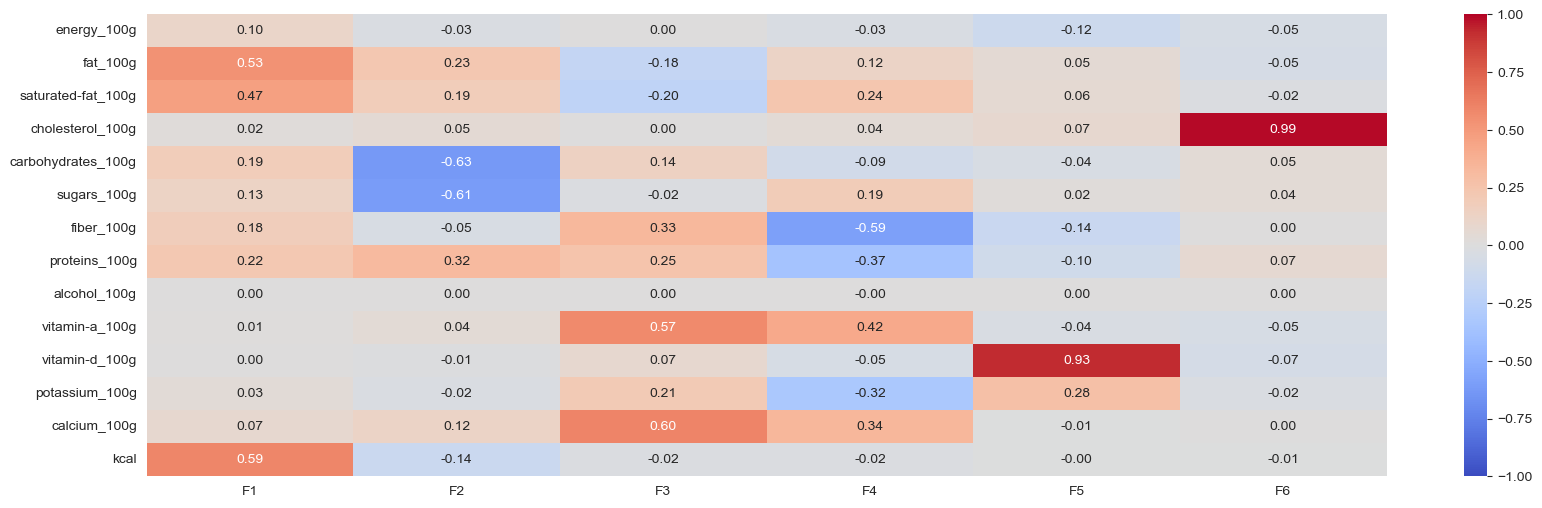

In [194]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

In [195]:
def correlation_graph(pca,
                      x_y,
                      features) :
    """Affiche le graphe des correlations

    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

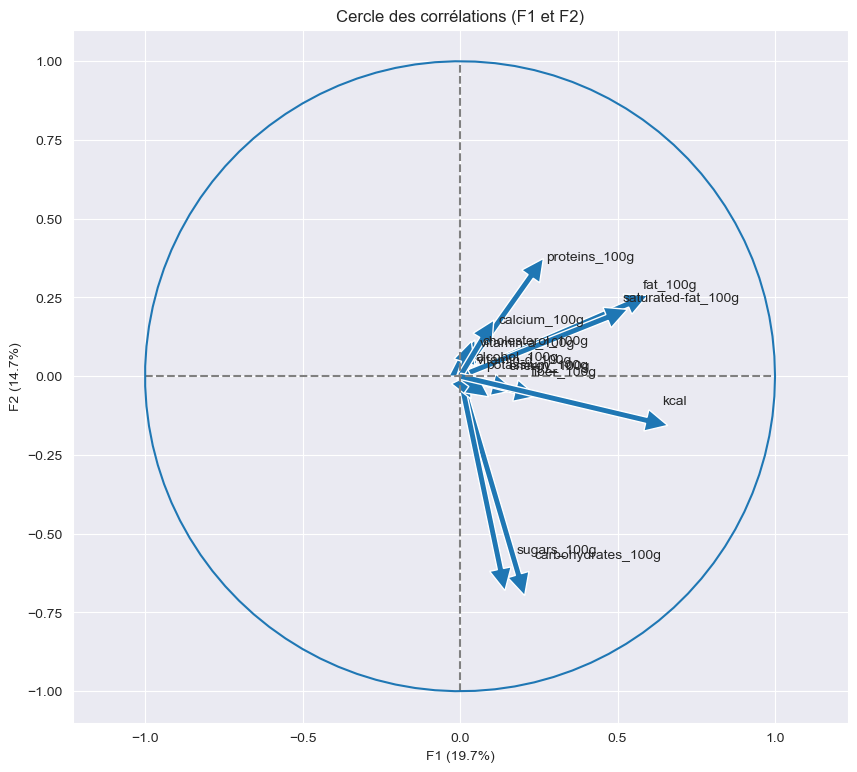

In [196]:
x_y = (0,1)
x_y
correlation_graph(pca, x_y, features)

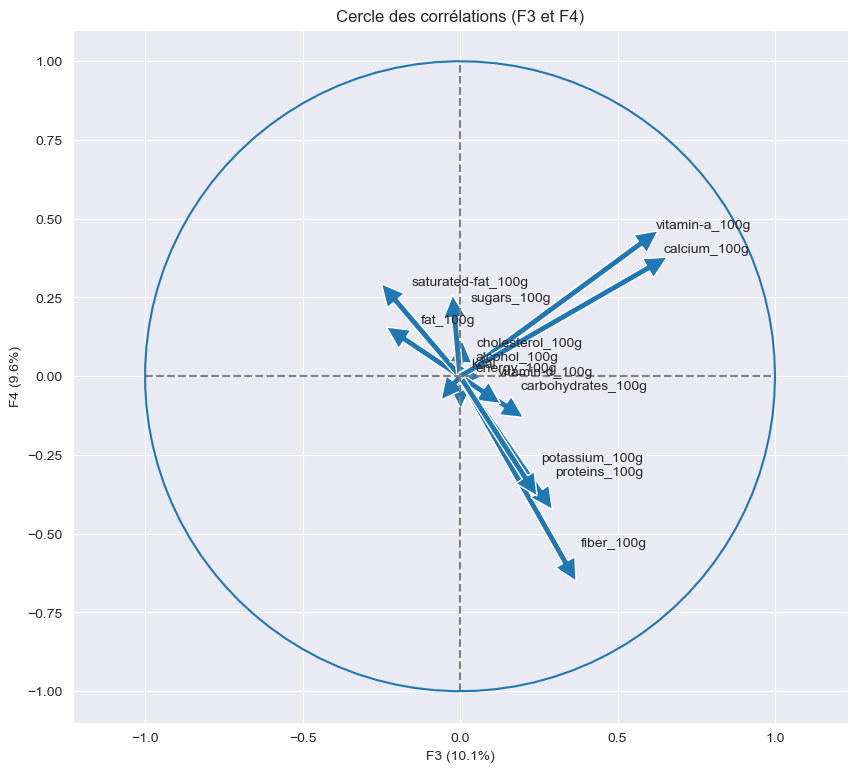

In [197]:
correlation_graph(pca, (2,3), features)

In [198]:
def display_factorial_planes(   X_projected,
                                x_y,
                                pca=None,
                                labels = None,
                                clusters=None,
                                alpha=1,
                                figsize=[10,8],
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments :
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments :
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8]
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize:
        figsize = (7,6)

    # On gère les labels
    if  labels is None :
        labels = []
    try :
        len(labels)
    except Exception as e :
        raise e

    # On vérifie la variable axis
    if not len(x_y) ==2 :
        raise AttributeError("2 axes sont demandées")
    if max(x_y )>= X_.shape[1] :
        raise AttributeError("la variable axis n'est pas bonne")

    # on définit x et y
    x, y = x_y

    # Initialisation de la figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters

    # Les points
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha,
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe
    if pca :
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else :
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) :
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center')

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()


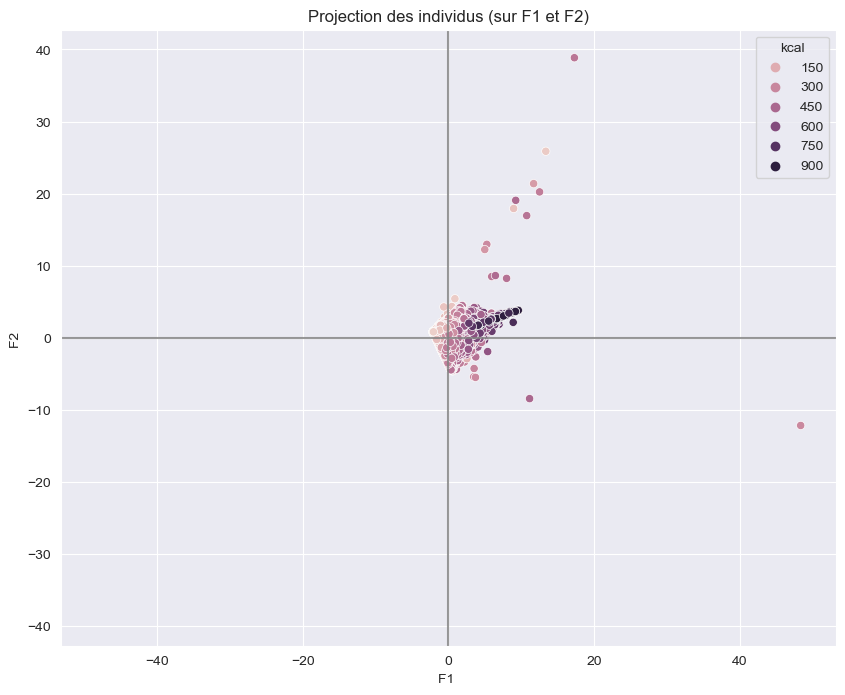

In [199]:
X_proj = pca.transform(X_scaled)
X_proj[:5]

x_y = [0,1]
display_factorial_planes(X_proj, x_y, clusters=data_acp['kcal'])